# Flow matching

In [48]:
from functools import partial

import jax
import jax.numpy as np
import flax.linen as nn
import optax
import diffrax as dfx
import tensorflow_probability.substrates.jax as tfp

from sklearn import datasets, preprocessing

import matplotlib.pyplot as plt
from tqdm import trange

(-2.0, 2.0)

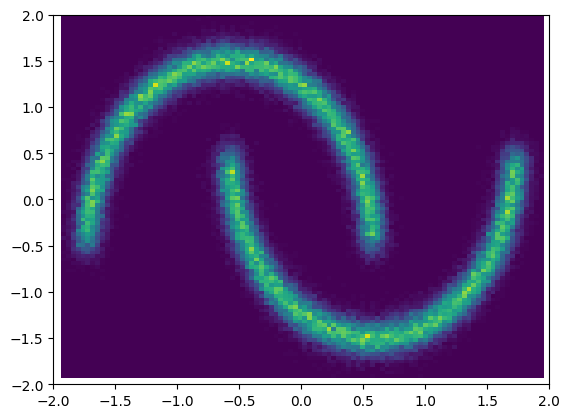

In [49]:
n_samples = 100_000

x, _ = datasets.make_moons(n_samples=n_samples, noise=.06)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

plt.hist2d(x[:, 0], x[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

In [50]:
dim_t_emb = 8

class MLP(nn.Module):
    """ A simple MLP in Flax.
    """
    hidden_dim: int = 32
    out_dim: int = 2
    n_layers: int = 2

    @nn.compact
    def __call__(self, x, t):
        
        x = np.concatenate([x, t], -1)
        
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x
    
def get_timestep_embedding(timesteps, embedding_dim: int, dtype=np.float32):
    """Build sinusoidal embeddings (from Fairseq)."""

    # Convert scalar timesteps to an array
    if np.isscalar(timesteps):
        timesteps = np.array([timesteps], dtype=dtype)

    assert len(timesteps.shape) == 1
    timesteps *= 1000

    half_dim = embedding_dim // 2
    emb = np.log(10_000) / (half_dim - 1)
    emb = np.exp(np.arange(half_dim, dtype=dtype) * -emb)
    emb = timesteps.astype(dtype)[:, None] * emb[None, :]
    emb = np.concatenate([np.sin(emb), np.cos(emb)], axis=1)
    if embedding_dim % 2 == 1:  # Zero pad
        emb = jax.lax.pad(emb, dtype(0), ((0, 0, 0), (0, 1, 0)))
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb

In [51]:
key = jax.random.PRNGKey(0)
t = np.ones((x.shape[0],))

t_emb = get_timestep_embedding(t, dim_t_emb)

v = MLP(hidden_dim=64, out_dim=2, n_layers=4)
params = v.init(key, x, t_emb)

In [52]:
sigma_min = 1e-3

def loss_fn(params, x, t, x0, phi):
    """ Optimal transport flow-matching loss.
    """
    t = t[:, None]
    psi = (1 - t) * x + (1 - (1 - sigma_min) * (1 - t)) * x0
    u = (1 - sigma_min) * x0 - x    

    t_emb = get_timestep_embedding(t[..., 0], dim_t_emb)
    return np.square(phi.apply(params, psi, t_emb) - u).mean()

loss_fn(params, x, t, np.zeros_like(x), v)

Array(1.0000116, dtype=float32)

In [53]:
opt = optax.adam(learning_rate=3e-4)
opt_state = opt.init(params)

In [54]:
n_steps = 3000
n_batch = 64

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]
        
        # Draw uniform times
        t_batch = jax.random.uniform(subkey, (n_batch,))
        x0_batch = jax.random.normal(subkey, (n_batch, 2))
        
        loss, grads = jax.value_and_grad(loss_fn)(params, x_batch, t_batch, x0_batch, v)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

100%|██████████| 3000/3000 [01:17<00:00, 38.78it/s, val=1.5524163] 


In [87]:
t0, t1, dt0 = 1., 0., -1e-2

def single_sample_fn(params, key, n_dim=2):
    """ Produce single sample from the CNF by integrating forward.
    """
    y = jax.random.normal(key, (n_dim,))

    def func(t, x, args):
        t = np.atleast_1d(t)
        t_emb = get_timestep_embedding(t, dim_t_emb)[0]
        return v.apply(params, x, t_emb)
    
    term = dfx.ODETerm(func)
    solver = dfx.Euler()
    sol = dfx.diffeqsolve(term, solver, t0, t1, dt0, y)
    (y,) = sol.ys
    return y

single_sample_fn(params, key)

Array([ 0.20321071, -0.75606686], dtype=float32, weak_type=True)

## Likelihood evaluation

In [88]:
sample_fn = partial(single_sample_fn, params)

n_samples = 1000
sample_key = jax.random.split(key, n_samples ** 2)
x_sample = jax.vmap(sample_fn)(sample_key)

(-2.0, 2.0)

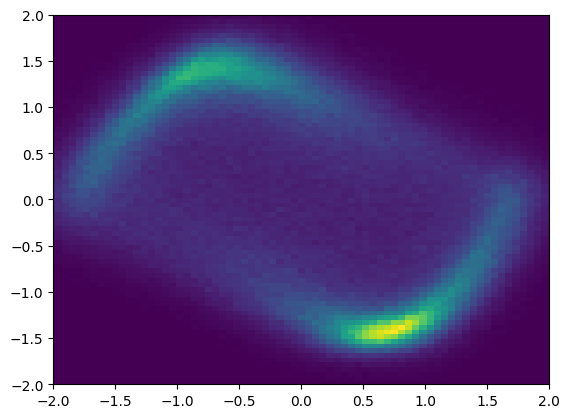

In [89]:
plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

In [97]:
def logp_exact(t, y, args):
    """ Compute trace directly.
    """
    y, _ = y
    t = np.atleast_1d(t)
    t_emb = get_timestep_embedding(t, dim_t_emb)[0]
    fn = lambda y: v.apply(params, y, t_emb)  # Time-augmented function
    f, f_vjp = jax.vjp(fn, y)  # VJPs can be computed at the ~same cost as computing f through reverse-mode AD

    # Compute trace
    (size,) = y.shape
    (dfdy,) = jax.vmap(f_vjp)(np.eye(size))
    logp = np.trace(dfdy)
    return f, logp

t0, t1, dt0 = 1., 0., -1e-2

def log_prob(y):
    term = dfx.ODETerm(logp_exact)
    solver = dfx.Dopri5()
    delta_log_likelihood = 0.0
    y = (y, delta_log_likelihood)
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y)
    (z,), (delta_log_likelihood,) = sol.ys
    log_prob = delta_log_likelihood + tfp.distributions.Normal(loc=0., scale=1.).log_prob(z).sum()
    return log_prob

jax.vmap(log_prob)(x_sample[:16])

Array([-2.0392256, -1.1206366, -2.65554  , -1.4063723, -2.2059798,
       -2.2443707, -0.9047518, -2.9549599, -2.1692946, -1.8222115,
       -2.423904 , -1.2887866, -2.8796754, -1.0549778, -2.7567716,
       -2.72397  ], dtype=float32)

In [98]:
# Make a grid between -2 and 2, and flatten it to pass to log_prob
x_grid = np.linspace(-2, 2, 100)
x_grid = np.stack(np.meshgrid(x_grid, x_grid), -1).reshape(-1, 2)

In [99]:
# Evaluate and reshape back to grid
x_loglike = jax.vmap(log_prob)(x_grid).reshape(100, 100)

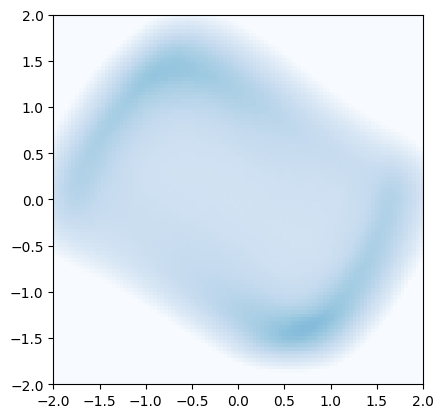

In [105]:
plt.imshow(x_loglike, origin='lower', extent=(-2, 2, -2, 2), cmap='Blues', vmin=-5, vmax=5)